# Tests for maps

# Author JJGC

## ilustration of tests for maps functions

In [85]:
%load_ext autoreload
%autoreload 2
import os
import sys
import time
import warnings
import datetime 
print("Last updated on ", time.asctime())

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Last updated on  Fri Feb 15 14:10:01 2019


### Notebook configuration

In [86]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = 10, 8
plt.rcParams["font.size"     ] = 14

In [87]:
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib
import tables            as tb
import random
import glob
import warnings
sns.set()

In [88]:
from krcal.core.core_functions      import timeit

In [89]:
from krcal.core.kr_types                 import KrEvent
from krcal.core.analysis_functions       import kr_event
from typing      import List, Tuple, Sequence, Iterable, Dict
from   pandas.core.frame import DataFrame

In [90]:
import logging
log = logging.getLogger()

In [317]:
from krcal.core.io_functions                 import filenames_from_list
from krcal.core.core_functions               import phirad_to_deg
from krcal.core.kr_types                     import Number
from krcal.core.kr_types                     import KrFileName
from  invisible_cities.io.dst_io             import load_dsts
from krcal.core.core_functions               import time_delta_from_time
from krcal.core.core_functions               import data_frames_are_identical
from krcal.core.analysis_functions           import kr_ranges_and_bins
from krcal.core.analysis_functions           import select_xy_sectors
from krcal.core.fit_lt_functions             import get_time_series
from krcal.core.analysis_functions           import event_map
from invisible_cities.core.core_functions    import in_range
from krcal.core.core_functions               import time_delta_from_time
from invisible_cities.icaro. hst_functions   import shift_to_bin_centers

In [301]:
from krcal.core.rphi_maps_functions          import rphi_sector_map_def
from krcal.core.rphi_maps_functions          import define_rphi_sectors
from krcal.core.rphi_maps_functions          import draw_wedges

In [92]:
import cProfile

In [93]:
import logging
log = logging.getLogger()

In [271]:
from numpy import pi

In [304]:
from krcal.core.selection_functions          import select_xy_sectors_df
from krcal.core.selection_functions          import select_rphi_sectors_df
from krcal.core.selection_functions          import get_time_series_df
from krcal.core.selection_functions          import event_map_df

## Prepare data

In [274]:
D = {}
D['X']      = np.random.uniform(low=-200, high=200, size=20)
D['Y']      = np.random.uniform(low=-200, high=200, size=20)
D['Z']      = np.random.uniform(low=0, high=500, size=20)
D['R']      = np.random.uniform(low=0, high=200, size=20)
D['Phi']    = np.random.uniform(low=-pi, high=pi, size=20)
D['S2e']    = np.random.uniform(low=5000, high=10000, size=20)
D['S1e']    = np.random.uniform(low=0, high=10, size=20)
D['S2q']    = np.random.uniform(low=0, high=100, size=20)
D['time']   = np.arange(0,100,5)
dst0         = pd.DataFrame.from_dict(D)

In [275]:
print(dst0)

             X           Y           Z           R       Phi          S2e  \
0    71.812019  -42.452912  308.580011  193.214689 -2.414363  6796.906561   
1   121.184480  136.445466  216.992253   89.131817 -1.186726  5864.588246   
2    27.623348 -164.951540   32.995226   96.817558 -1.021389  8071.294810   
3   101.971148  -82.100068  226.240311  151.291569  0.743287  7551.659687   
4   132.055092 -166.028793  291.938796   54.133194 -2.396242  6501.295561   
5   170.301807  -25.730063  332.929736  128.123209 -2.147433  6117.319226   
6   154.782312  141.407678  362.372189   45.280288  1.899512  9862.477012   
7    70.577616   21.147776  245.490635  169.741147  1.633419  5951.979248   
8   -58.525105 -121.989988  484.229713  155.323782 -2.535831  6497.732366   
9  -125.873172  -32.678165   58.819241   40.909191  0.794449  7926.165196   
10 -131.359283  -44.355435  271.521157  190.460580 -2.401494  9217.267882   
11    0.364440   66.470231  441.110753   97.760119 -2.033681  9948.109751   

In [310]:
dst0.columns

Index(['X', 'Y', 'Z', 'R', 'Phi', 'S2e', 'S1e', 'S2q', 'time'], dtype='object')

### Sort data frame in terms of time

In [311]:
dst_time = dst0.sort_values('time')
print(dst_time)

             X           Y           Z           R       Phi          S2e  \
0    71.812019  -42.452912  308.580011  193.214689 -2.414363  6796.906561   
1   121.184480  136.445466  216.992253   89.131817 -1.186726  5864.588246   
2    27.623348 -164.951540   32.995226   96.817558 -1.021389  8071.294810   
3   101.971148  -82.100068  226.240311  151.291569  0.743287  7551.659687   
4   132.055092 -166.028793  291.938796   54.133194 -2.396242  6501.295561   
5   170.301807  -25.730063  332.929736  128.123209 -2.147433  6117.319226   
6   154.782312  141.407678  362.372189   45.280288  1.899512  9862.477012   
7    70.577616   21.147776  245.490635  169.741147  1.633419  5951.979248   
8   -58.525105 -121.989988  484.229713  155.323782 -2.535831  6497.732366   
9  -125.873172  -32.678165   58.819241   40.909191  0.794449  7926.165196   
10 -131.359283  -44.355435  271.521157  190.460580 -2.401494  9217.267882   
11    0.364440   66.470231  441.110753   97.760119 -2.033681  9948.109751   

### Compute a vector of time differences

In [312]:
T       = dst_time.time.values
DT      = time_delta_from_time(T)
print(DT)

[ 0  5 10 15 20 25 30 35 40 45 50 55 60 65 70 75 80 85 90 95]


### Expand the DST with DT

In [313]:
dst = dst_time.assign(DT=DT)
print(dst)

             X           Y           Z           R       Phi          S2e  \
0    71.812019  -42.452912  308.580011  193.214689 -2.414363  6796.906561   
1   121.184480  136.445466  216.992253   89.131817 -1.186726  5864.588246   
2    27.623348 -164.951540   32.995226   96.817558 -1.021389  8071.294810   
3   101.971148  -82.100068  226.240311  151.291569  0.743287  7551.659687   
4   132.055092 -166.028793  291.938796   54.133194 -2.396242  6501.295561   
5   170.301807  -25.730063  332.929736  128.123209 -2.147433  6117.319226   
6   154.782312  141.407678  362.372189   45.280288  1.899512  9862.477012   
7    70.577616   21.147776  245.490635  169.741147  1.633419  5951.979248   
8   -58.525105 -121.989988  484.229713  155.323782 -2.535831  6497.732366   
9  -125.873172  -32.678165   58.819241   40.909191  0.794449  7926.165196   
10 -131.359283  -44.355435  271.521157  190.460580 -2.401494  9217.267882   
11    0.364440   66.470231  441.110753   97.760119 -2.033681  9948.109751   

Phi (deg) = [ 41.66719269 112.00559716 121.47873837 222.58720158  42.70546798
  56.96116359 288.83402263 273.58800485  34.70758116 225.51859372
  42.4045011   63.47863615 344.51482947 268.26152589 202.88661388
 328.77366092 197.11711474 223.29257812 357.41476533 205.58776719]


In [ ]:
print(f'Phi (deg) = {phirad_to_deg(dst.Phi.values)}')

## Selection functions

### event_map_df

```
def event_map_df(dstMap : Dict[int, List[DataFrame]])->DataFrame:
    """
    Compute a numerical map from a DataFrame map

    Parameters
    ----------
    dstMAP:
        A DataFrame map, e.g, a Dict[int, List[DataFrame]]

    Returns
    -------
        A DataFrame in which each entry corresponds to the length of the
        DataFrames in the map.

    """
````

In [280]:
len(dst)

20

In [281]:
dstMap={0:[dst]}

In [282]:
em = event_map_df(dstMap)
em

,0
0,20


In [283]:
em[0][0] == len(dst)

True

### Time series

```
def get_time_series_df(time_bins    : Number,
                       time_range   : Tuple[float, float],
                       dst          : DataFrame,
                       time_column  : str = 'DT')->Tuple[np.array, List[np.array]]:
    """

    Given a dst (DataFrame) with a time column specified by the name time,
    this function returns a time series (ts) and a list of masks which are used to divide
    the event in time tranches.

    More generically, one can produce a "time series" using any column of the dst
    simply specifying time_column = ColumName

        Parameters
        ----------
            time_bins
                Number of time bines.
            time_range
                Time range.
            dst
                A Data Frame
            time_column
            A string specifyng the dst column to be divided in time slices.

        Returns
        -------
            A Tuple with:
            np.array       : This is the ts vector
            List[np.array] : This are the list of masks defining the events in the time series.

    """
```


#### Example: compute the time series for 5 bins, between DT[0] and DT[-1]

In [284]:
ts, masks = get_time_series(5,(dst.DT.values[0], dst.DT.values[-1]), dst)

In [285]:
print(f'time series bins = {ts}')

time series bins = [ 9.5 28.5 47.5 66.5 85.5]


In [286]:
print(f'masks = {np.array(masks)}')

masks = [[ True  True  True  True False False False False False False False False
  False False False False False False False False]
 [False False False False  True  True  True  True False False False False
  False False False False False False False False]
 [False False False False False False False False  True  True  True  True
  False False False False False False False False]
 [False False False False False False False False False False False False
   True  True  True  True False False False False]
 [False False False False False False False False False False False False
  False False False False  True  True  True False]]


In [287]:
ts2, masks2 = get_time_series_df(5,(dst.DT.values[0], dst.DT.values[-1]), dst, time_column='time')

In [288]:
np.equal(masks, masks2).all()

True

In [289]:
np.equal(ts, ts2).all()

True

## select_xy_sectors_df

```
def select_xy_sectors_df(dst        : DataFrame,
                         bins_x     : np.array,
                         bins_y     : np.array)-> Dict[int, List[DataFrame]]:
    """
    Return a DataFrameMap of selections organized by xy sector
    DataFrameMap = Dict[int, List[DataFrame]]

    Parameters
    ----------
        dst:
        The input data frame.
        bins_x:
        An array of bins along x.
        bins_y:
        An array of bins along y.

    Returns
    -------
        A DataFrameMap of selections
        where for each x (the key in the dict) one has a list
        (corresponding to y cells) of DataFrame (the events selected)

    """

```

#### Define XY bins

In [291]:
xb = np.arange(0,201,25)
yb = np.arange(0,201,25)
nbx = len(xb) -1
nby = len(yb) -1
print(f'xb, nbx = {xb, nbx}')
print(f'yb, nby = {yb, nby}')

xb, nbx = (array([  0,  25,  50,  75, 100, 125, 150, 175, 200]), 8)
yb, nby = (array([  0,  25,  50,  75, 100, 125, 150, 175, 200]), 8)


#### Check ranges

In [292]:
def x_and_y_ranges(data, xb, yb, nbx, nby):
    r = True
    for i in range(nbx):
        dstx = data[in_range(data.X, *xb[i: i+2])]
        r & in_range(dstx.X.values, xb[i: i+2][0], xb[i: i+2][1]).all()
        for j in range(nby):
            dsty = dstx[in_range(dstx.Y, *yb[j: j+2])]
            r & in_range(dsty.Y.values, yb[j: j+2][0], yb[j: j+2][1]).all()
    return r

In [293]:
x_and_y_ranges(data, xb, yb, nbx, nby)

True

#### Fill dict

In [294]:
selDict = {}
for i in range(nbx):
    dstx = data[in_range(data.X, *xb[i: i+2])]
    selDict[i] = [dstx[in_range(dstx.Y, *yb[j: j+2])] for j in range(nby) ]

sel = event_map_df(selDict)

In [295]:
sel

,0,1,2,3,4,5,6,7
0,1,0,1,1,0,0,0,0
1,1,2,3,1,0,0,0,0
2,1,0,0,1,0,0,0,0
3,1,2,4,1,0,0,0,0
4,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0


#### Call function and make counting map

In [296]:
selMap = select_xy_sectors_df(data, xb, yb)

In [297]:
sel2 = event_map_df(selMap)

#### Compare data frames

In [298]:
data_frames_are_identical(sel, sel2)

True

## select_rphi_sectors_df

```
    """
    Return a dict of KrEvent organized by rphi sector.

    Parameters
    ----------
        dst:
        The input data frame.

        RPS:
        RPHI selection, a map defining the RPHI wedges.

    Returns
    -------
        A DataFrameMap of selections
        where for each radial sector (the key in the dict) one has a list
        (corresponding to the PHI sectors) of DataFrame (the events selected)

    """

```

#### To compute a RPHI map, the first step is to define a KrSector map which contains the definition of the RPHI wedges:

1. Call rphi_sector_map_def():

```
def rphi_sector_map_def(nSectors : int   =10,
                        rmax     : float =200,
                        sphi     : float =45)->RPhiMapDef:
@dataclass
class RPhiMapDef:  # defines the values in (R,Phi) to compute RPHI maps
    r   : Dict[int, Tuple[float, float]] # (rmin, rmax) in each radial sector
    phi : Dict[int, List[Tuple[float, float]]] # (phi_0, ph_1... phi_s) per radial sector
```

2. Call define_rphi_sectors():
```
def define_rphi_sectors(rpmf : RPhiMapDef)-> Dict[int, List[KrSector]]:
    """
    Compute a map (defined as a Dict[int, List[]]) of KrSectors`
```

3. The KrSector map (W) can be drawn (with draw_wedges), and then used to compute selection maps

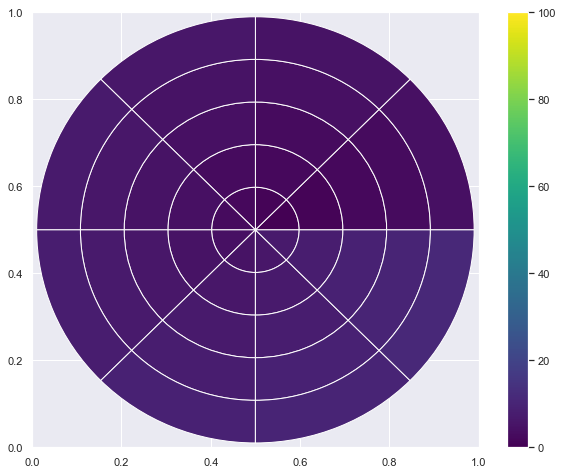

In [302]:
NSECTORS =5  # number of sectors in R. Each sector then is 200 / 5 = 40 cm.
SPHI     =45 # size of the phi pie-slice in degrees, thus 10 slices in phi.
RMAX      = 200
rpsmd = rphi_sector_map_def(nSectors=NSECTORS, rmax=RMAX, sphi=SPHI)
W     = define_rphi_sectors(rpsmd)
draw_wedges(W,  rmax = RMAX, 
            scale= 0.49, figsize=(10,8), alpha=1.0,
            cr =range(NSECTORS))

In [314]:
KSRP = select_rphi_sectors_df(dst, W)

In [323]:
neM = event_map_df(KSRP)

In [324]:
neM

,0,1,2,3,4
0,0,1,0,1,2
1,0,0,1,1,0
2,0,0,2,0,0
3,0,0,0,0,0
4,0,1,0,1,3
5,0,1,0,1,0
6,0,1,0,0,1
7,1,0,1,0,1


## END